# librerias

In [1]:
import exoplanet

import pytensor.tensor as pt
import exoplanet as xo
import pymc as pm

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

import sys
sys.path.insert(0, '/Users/paula/Documents/school_of_summer/Copia-NWelch-main/src')

import TimeSeries
import Bivariate as Bi
from scipy.optimize import curve_fit

exoplanet.__version__ = '0.6.0'


## Start GJ-1002
Data are from <a href="https://ui.adsabs.harvard.edu/abs/2023A%26A...670A...5S/abstract">	
Mascareño et al. (2023)</a>

# Read Data

In [2]:
data = pd.read_csv('GJ1002_SuarezMascareno_2023.txt', delim_whitespace=True,
                  header=None, comment='#', skiprows=50,
                  names=['BJD-2450000', 'RV1', 'RV2', 'RV3', 'RV4', 'e_RV', 'FWHM1', 'FWHM2',
                         'FWHM3', ' e_FWHM', 'Temp', 'Inst'])
data  

/var/folders/n2/qpbrzh194y571g9lfznmxsb00000gq/T/ipykernel_40735/2079146661.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('GJ1002_SuarezMascareno_2023.txt', delim_whitespace=True,


,BJD-2450000,RV1,RV2,RV3,RV4,e_RV,FWHM1,FWHM2,FWHM3,e_FWHM,Temp,Inst
0,7595.622,-1.27,-1.64,-2.10,-1.25,1.50,-0.78,2.86,3.83,12.09,9,0
1,7596.621,0.69,0.31,-0.33,-0.34,1.49,-5.51,-1.87,-0.82,11.93,9,0
2,7606.655,7.91,7.54,5.67,3.70,1.75,11.11,14.74,12.73,12.22,-12,0
3,7610.647,2.51,2.13,0.37,0.49,1.44,5.72,9.35,8.65,12.26,-4,0
4,7613.597,-1.40,-1.78,-3.26,-0.87,1.70,0.39,4.03,4.15,12.36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
134,9555.545,0.97,0.47,1.87,0.34,0.29,-0.28,-0.46,0.22,1.38,9,3
135,9556.558,-0.46,-0.96,0.64,-0.04,0.29,-0.20,-0.38,0.34,1.38,10,3
136,9557.561,-1.33,-1.83,-0.04,0.04,0.25,-0.78,-0.96,-0.20,1.16,11,3
137,9563.590,-2.09,-2.59,0.30,-0.06,0.23,-2.04,-2.21,-1.71,1.03,6,3


In [31]:
t = data['BJD-2450000'].values
pb=10.3465
pc= 20.202
planets = [1/pb]

Periodograms

Number of data points per segment: 92
frequency associated with the median timestep. Make sure that makes
sense for your dataset.
Number of segments: 2
Segment start and end points: [[  0  92]
 [ 46 139]]
Effective number of segments: 1.600000
Frequency grid spacing: 0.000112
Minimum 6-dB main lobe half width: 0.000815
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000920
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000673


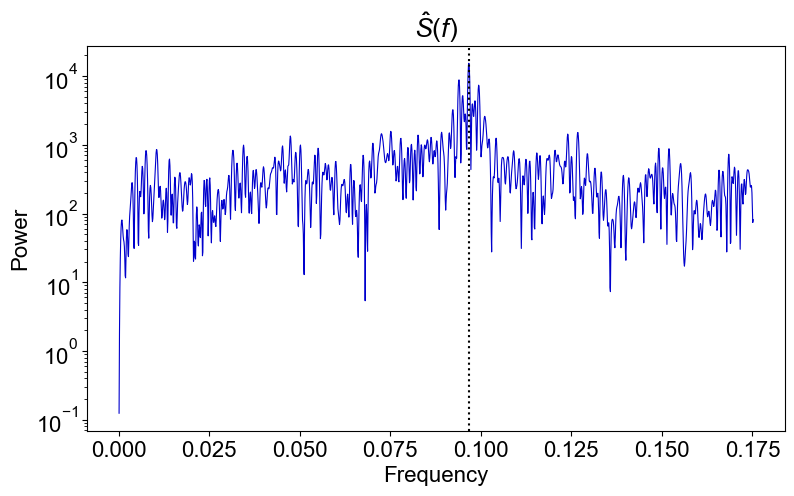

In [32]:
np.random.seed(876)
nyquistm = 0.03504
N = np.random.randn(len(t))
temp=np.sin(2 * np.pi * 1/pb * t )#+(0.3+N)
temp2=TimeSeries.TimeSeries(t,temp, display_frequency_info=False)
temp2.segment_data(2, 5*nyquistm, window = 'None', plot_windows = False)
temp2.Welch_powspec()
temp2.powplot(Welch=True, vlines=planets)


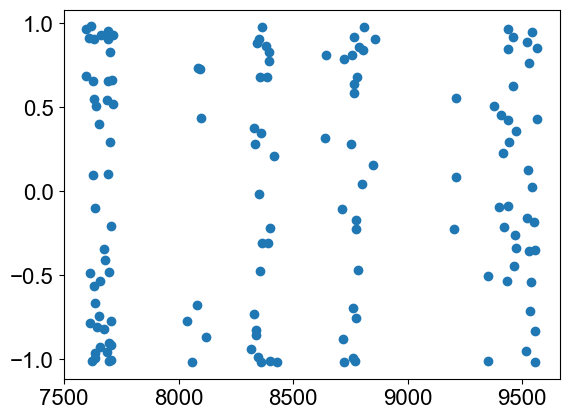

In [5]:
temp = temp-np.mean(temp)
plt.plot(t,temp, 'o')           

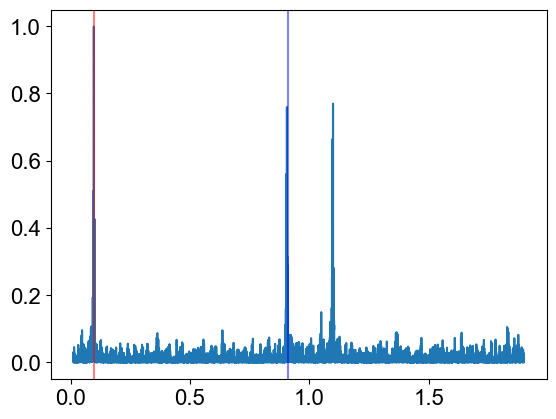

In [6]:
frequency, power = LombScargle(t, temp).autopower(minimum_frequency=0.01,
                                                   maximum_frequency=1.9)
len(frequency)
plt.plot(frequency, power)   
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 1)
ls = LombScargle(t, temp)
y_fit = ls.model(t, best_frequency)
plt.axvline(best_frequency, color='red', alpha=0.5)
plt.axvline(1/1.1, color='blue', alpha=0.5)

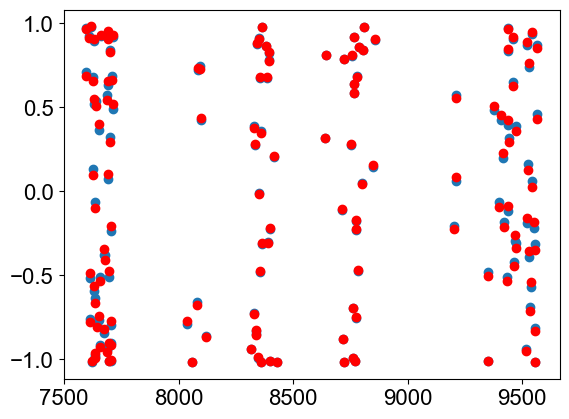

In [7]:
plt.plot(t, y_fit, 'o')
plt.plot(t,temp, 'o', color='r')


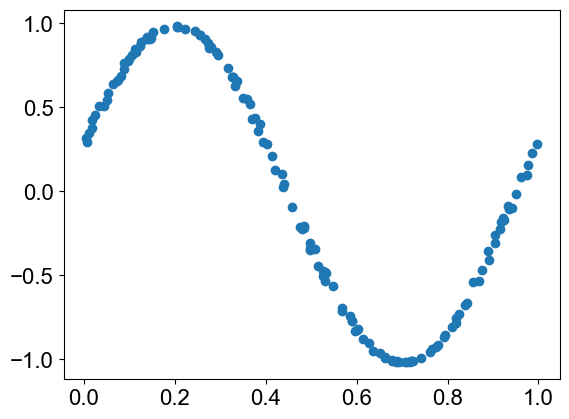

In [8]:
plt.plot((t % (1/ best_frequency ))/(1/ best_frequency ), temp, 'o' )

# Model Usig https://docs.exoplanet.codes/en/latest/ 

In [9]:
ti = np.linspace(min(t), max(t),500)
with pm.Model() as model:
    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=np.log(200),
        #initval=np.log(0.5 * (np.max(temp) - np.min(temp))),
    )
    logP = pm.Uniform(
        "logP", lower=0, upper=np.log(100), initval=np.log(pb)
    )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi,) #initval=0.01)

    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
    e = pm.Deterministic("e", h**2 + k**2)
    w = pm.Deterministic("w", pt.arctan2(k, h))

    rv0 = pm.Normal("rv0", mu=0.0, sigma=10.0, initval=0.0)
    #rvtrend = pm.Normal("rvtrend", mu=0.0, sigma=10.0, initval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * pt.exp(-logP)
    P = pm.Deterministic("P", pt.exp(logP))
    K = pm.Deterministic("K", pt.exp(logK))
    cosw = pt.cos(w)
    sinw = pt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    #bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    bkg = pm.Deterministic("bkg", rv0)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + pt.zeros_like(M))
    orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=t0, ecc= e, omega=w)
    
    rvmodel = pm.Deterministic(
        "rvmodel",bkg+orbit.get_radial_velocity(t,K=K ))
    #rvmodel = pm.Deterministic(
    #    "rvmodel", bkg + K * (cosw * (pt.cos(f) + e) - sinw * pt.sin(f))
    #)
    pm.Deterministic('rv_plot',orbit.get_radial_velocity(ti,K=K ))    # Condition on the observations
    #pm.Normal("obs", mu=rvmodel, sigma=data['e_RV'].values, observed=temp)
    pm.Normal("obs", mu=rvmodel, observed=temp)
   

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + pt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (pt.cos(f_pred) + e) - sinw * pt.sin(f_pred))
    )

In [10]:
np.log(pb)

2.3366482982697465

In [11]:
with model:
    map_params = pm.find_MAP()

Output()

10.350091320580056


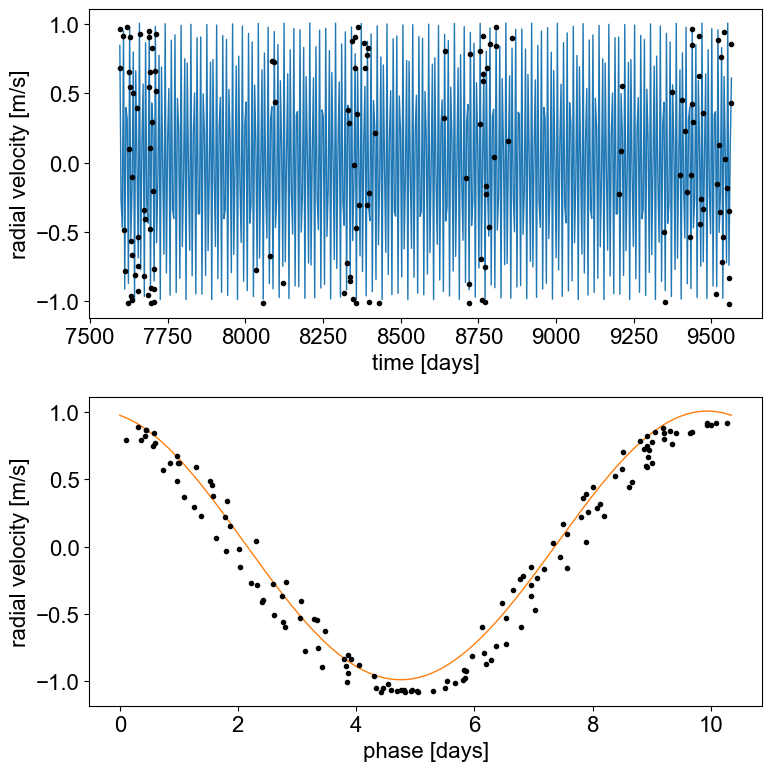

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]
print(period)

ax = axes[0]
#ax.errorbar(t, temp, yerr=data['e_RV'].values, fmt=".k")
ax.errorbar(t, temp, fmt=".k")
ax.plot(ti, map_params["rv_plot"], color="C0", lw=1)
#ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
#ax.errorbar(t % period, temp - map_params["bkg"], yerr=data['e_RV'].values, fmt=".k")
ax.errorbar(t % period, temp - map_params["bkg"], fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
#ax.set_ylim(-110, 110)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

Analysis with Residuals

In [13]:
residuals=temp- map_params["rvmodel"] #residuals

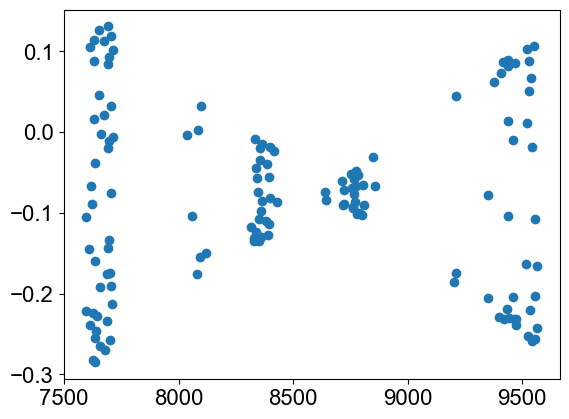

In [14]:
plt.plot(t,residuals, 'o')

In [15]:
Residualst=TimeSeries.TimeSeries(t,residuals)

Nyquist frequency from mean dt: 0.03504
Nyquist frequency from 10% trimmed mean dt: 0.09190
Nyquist frequency from 20% trimmed mean dt: 0.11892
Nyquist frequency from median dt: 0.16714
Rayleigh resolution: 0.00051


In [16]:
Residualst.frequency_grid(0.16714 ) 
Residualst.pow_FT()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


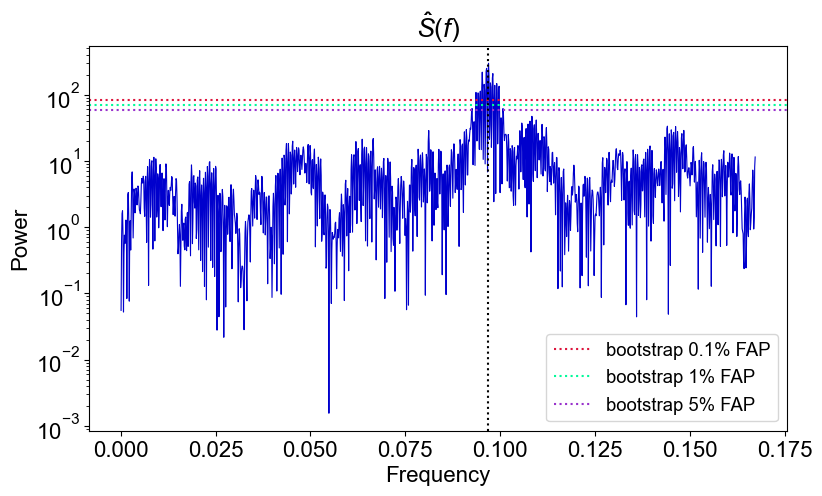

In [17]:
planets = [1/pb]
Residualst.powplot(vlines=planets)

Number of data points per segment: 92
frequency associated with the median timestep. Make sure that makes
sense for your dataset.
Number of segments: 2
Segment start and end points: [[  0  92]
 [ 46 139]]
Effective number of segments: 1.600000
Frequency grid spacing: 0.000112
Minimum 6-dB main lobe half width: 0.000815
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000920
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000673


<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
/var/folders/n2/qpbrzh194y571g9lfznmxsb00000gq/T/ipykernel_40735/749559380.py:3: SyntaxWarning: invalid escape sequence '\h'
  Residualst.powplot(title='Residuals $\hat{S}(f)$',Welch=True, vlines=planets)


Text(0.5, 0, 'Frequency (1/day)')

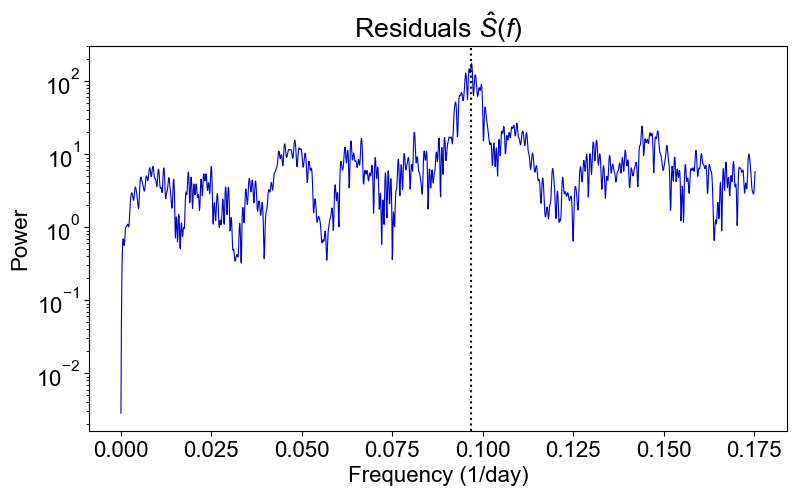

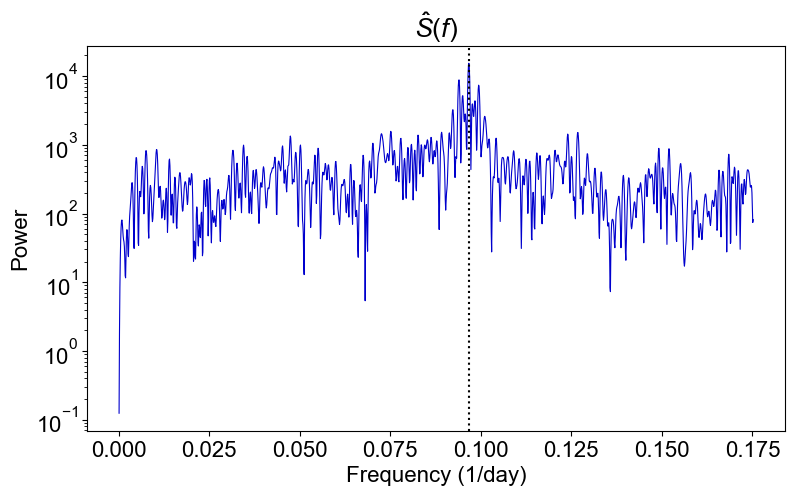

In [37]:
Residualst.segment_data(2, 5*nyquistm, window = 'None', plot_windows = False)
Residualst.Welch_powspec()
Residualst.powplot(title='Residuals $\hat{S}(f)$',Welch=True, vlines=planets)
plt.xlabel('Frequency (1/day)')
temp2.powplot(Welch=True, vlines=planets)
plt.xlabel('Frequency (1/day)')

# SCIPY

In [19]:
def seno(t, pb, phase, A, c):
    return A* np.sin(2 * np.pi * 1/pb * t + phase) +c

In [20]:
popt, pcov = curve_fit(seno, t, temp, bounds=([5,0,1,0], [15, 2 * np.pi, 5,5]))
popt

array([10.01040253,  6.28318531,  1.        ,  0.06599213])

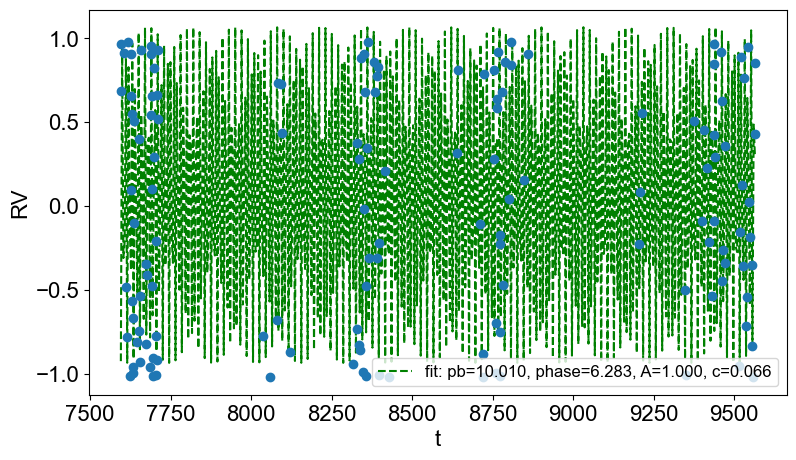

In [21]:
plt.figure(figsize=(9,5))
#plt.plot(t, seno(t, *popt), 'g--',
#         label='fit: pb=%5.3f, phase=%5.3f, A=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(ti, seno(ti, *popt), 'g--',
         label='fit: pb=%5.3f, phase=%5.3f, A=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(t,temp,'o')
plt.xlabel('t')
plt.ylabel('RV')
plt.legend(fontsize=12, loc='lower right')
plt.show()

In [22]:
#probar con ruidos, y con fases, pasar a la funcion de curfit

In [27]:
# temp=np.sin(2 * np.pi * 1/pb * t )+(0.3+N)
N2= np.random.randn(len(t))
temp2=np.sin(2 * np.pi * 1/pb * t )+(0.03+N2)

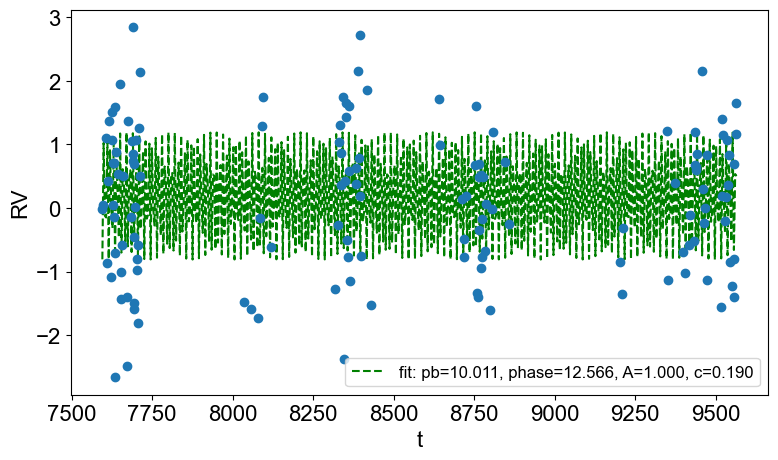

In [30]:
popt, pcov = curve_fit(seno, t, temp2, bounds=([5,0,1,0], [15, 4 * np.pi, 5,5]))
popt

plt.figure(figsize=(9,5))
#plt.plot(t, seno(t, *popt), 'g--',
#         label='fit: pb=%5.3f, phase=%5.3f, A=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(ti, seno(ti, *popt), 'g--',
         label='fit: pb=%5.3f, phase=%5.3f, A=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(t,temp2,'o')
plt.xlabel('t')
plt.ylabel('RV')
plt.legend(fontsize=12, loc='lower right')
plt.show()

In [25]:
print(popt)

[10.01113738 12.56637061  1.          0.07132533]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


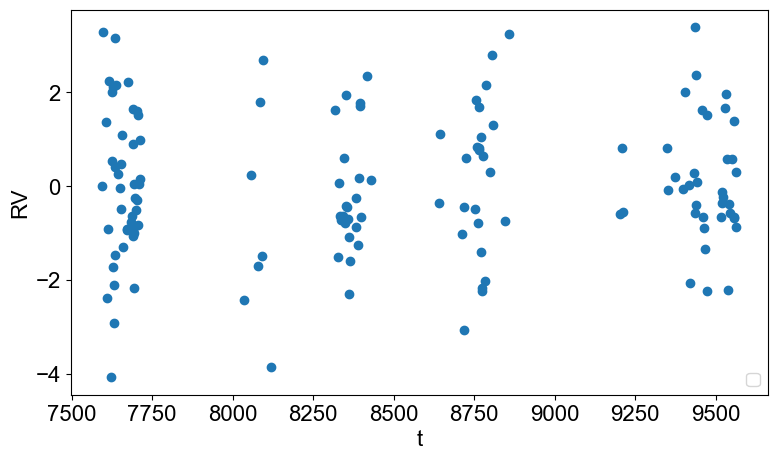

In [26]:
plt.figure(figsize=(9,5))
plt.plot(t, temp - seno(t, *popt),'o')
plt.xlabel('t')
plt.ylabel('RV')
plt.legend(fontsize=12, loc='lower right')
plt.show()
